In [1]:
import MDAnalysis
import numpy as np
import matplotlib.pyplot as plt

In [13]:
u = MDAnalysis.Universe('md.tpr','md.trr')

## Visualisation
Visualise the trajectory using <code> nglview </code>

In [67]:
import nglview as nv
v = nv.show_mdanalysis(u)
system = v.component_0
system.clear()
v.camera='orthographic'
v.center()
v.add_unitcell()
v.parameters = {"fogNear": 20}

SURF = u.select_atoms('resname WALL')
system.add_spacefill(selection = SURF.atoms.indices)
SOL=u.select_atoms('resname SOL')
system.add_spacefill(selection = SOL.atoms.indices)

v.control.spin([0, 1, 0], np.pi/2)

In [70]:
v.display()

NGLWidget(max_frame=25000)

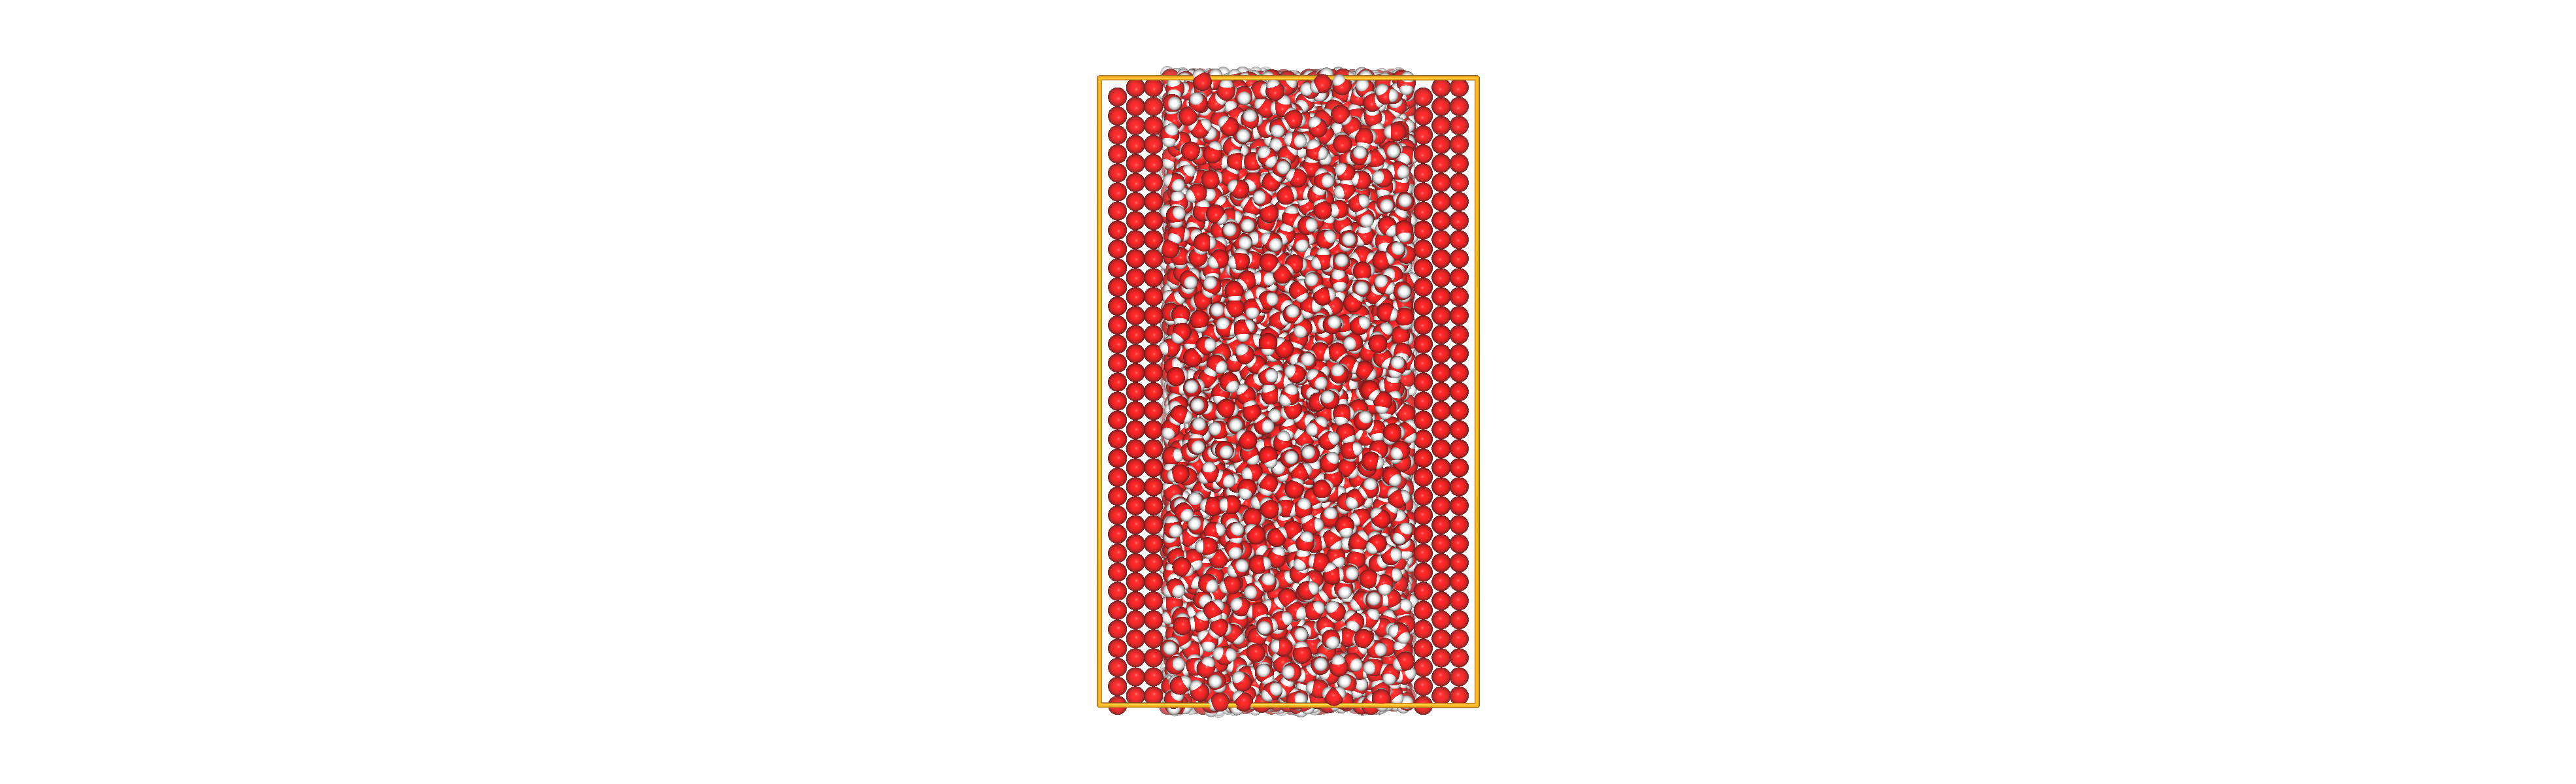

In [71]:
v._display_image()

## Calculation of the interfacial potential

In [16]:
SOL=u.select_atoms('resname SOL')
valdip = []; ozp = [];
frames = len(u.trajectory)
    
for step in u.trajectory:
    
    # dipole moment calculation
    lines=SOL.positions
    
    Ot0 = lines[::3]; H1t0 = lines[1::3]; H2t0 = lines[2::3]; 
    dipVector0 = (H1t0 - Ot0)/10*0.41 + (H2t0 - Ot0)/10*0.41 # spc water
    unitdipVector0 = dipVector0 / np.linalg.norm(dipVector0, axis=1)[:, None]
    
    j = 0
    while j < len(Ot0):
        valdip.append(dipVector0[j][2]) # dipole moments
        ozp.append(Ot0[j][2]) # O atom positions
        j += 1

In [ ]:
from scipy.stats import binned_statistic # This function allows the computation of the sum, mean, median, or other statistic of the values (or set of values) within each bin.
dipoles, bin_edges, binnumber = binned_statistic(ozp, valdip, statistic='mean', bins=np.linspace(5,55,5000))
bin_width = (bin_edges[1] - bin_edges[0]); bin_centers = bin_edges[1:] - bin_width/2; lxn=bin_centers/10

Text(0, 0.5, 'μ(z) (e nm)')

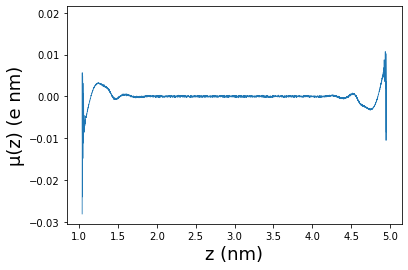

In [32]:
plt.plot(lxn,dipoles,lw=0.8)
plt.xlabel('z (nm)', fontsize=18)
plt.ylabel('μ(z) (e nm)', fontsize=18)

In [18]:
bin_means2, bin_edges2, binnumber2 = binned_statistic(ozp, valdip, statistic='count', bins=bin_edges)
binvolume = bin_width/10 * u.trajectory[0].dimensions[0] * u.trajectory[0].dimensions[1] / 100
Pz = ((dipoles/binvolume)*(bin_means2/frames)) # dipole moment density

In [35]:
pmidav = np.mean(Pz[2000:3000])
Pzexcess=Pz#-pmidav #if studying a charged case, subtract the continuum baseline pmidav
pmidav # polarisation in the bulk

1.2449083628503798e-05

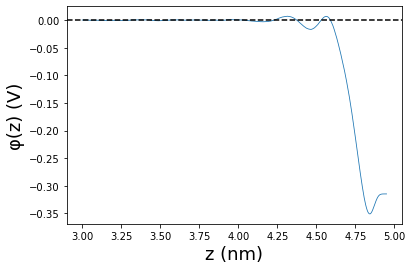

In [39]:
import scipy.integrate as sci
eoinv = 18.09512817972783 #1/epsilon0
Pzright=Pzexcess[len(Pzexcess)//2:]
lxnrev=lxn[::-1]; Pzexcessrev=Pzexcess[::-1]
POTRIGHT=(sci.cumtrapz(Pzright,lxn[len(Pzexcess)//2:],initial=0)*eoinv)
POTLEFT=(sci.cumtrapz(Pzexcessrev[len(Pzexcess)//2:],lxnrev[len(Pzexcess)//2:],initial=0)*eoinv)
#plt.plot(lxnrev[len(potential)//2:],POTLEFT,lw=0.8)
plt.plot(lxn[len(Pzexcess)//2:],POTRIGHT,lw=0.8)

plt.axhline(0, color='black',linestyle='--')
plt.xlabel('z (nm)', fontsize=18)
plt.ylabel('φ(z) (V)', fontsize=18)
plt.show()